## Train and Prediction on valid data

Using rotated to hz + OpenCv border

Basic default transforms

see:

https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb

and

https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs_more.ipynb

mem use 3GB with bs=32 TODO increase

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from torchvision.models import *
from efficientnet_pytorch import EfficientNet
import pretrainedmodels

In [3]:
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [4]:
__version__

'1.0.59.dev0'

In [5]:
m = EfficientNet.from_pretrained('efficientnet-b3')

Loaded pretrained weights for efficientnet-b3


In [6]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

In [7]:
def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

In [8]:
arch_summary(lambda _: m)

(0) Conv2dStaticSamePadding: 2   layers (total: 2)
(1) BatchNorm2d : 1   layers (total: 3)
(2) ModuleList  : 410 layers (total: 413)
(3) Conv2dStaticSamePadding: 2   layers (total: 415)
(4) BatchNorm2d : 1   layers (total: 416)
(5) AdaptiveAvgPool2d: 1   layers (total: 417)
(6) Dropout     : 1   layers (total: 418)
(7) Linear      : 1   layers (total: 419)
(8) MemoryEfficientSwish: 1   layers (total: 420)


In [9]:
arch_summary(lambda _: list(m.children())[2])

(0) MBConvBlock : 13  layers (total: 13)
(1) MBConvBlock : 13  layers (total: 26)
(2) MBConvBlock : 16  layers (total: 42)
(3) MBConvBlock : 16  layers (total: 58)
(4) MBConvBlock : 16  layers (total: 74)
(5) MBConvBlock : 16  layers (total: 90)
(6) MBConvBlock : 16  layers (total: 106)
(7) MBConvBlock : 16  layers (total: 122)
(8) MBConvBlock : 16  layers (total: 138)
(9) MBConvBlock : 16  layers (total: 154)
(10) MBConvBlock : 16  layers (total: 170)
(11) MBConvBlock : 16  layers (total: 186)
(12) MBConvBlock : 16  layers (total: 202)
(13) MBConvBlock : 16  layers (total: 218)
(14) MBConvBlock : 16  layers (total: 234)
(15) MBConvBlock : 16  layers (total: 250)
(16) MBConvBlock : 16  layers (total: 266)
(17) MBConvBlock : 16  layers (total: 282)
(18) MBConvBlock : 16  layers (total: 298)
(19) MBConvBlock : 16  layers (total: 314)
(20) MBConvBlock : 16  layers (total: 330)
(21) MBConvBlock : 16  layers (total: 346)
(22) MBConvBlock : 16  layers (total: 362)
(23) MBConvBlock : 16  laye

In [10]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [11]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [12]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [13]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [14]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [15]:
RETRAIN = True
RESIZE_IMAGES = True

In [16]:
MODEL_NAME='efficientnet'

In [17]:
NB_NUM='06_9'

In [18]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 058bce67, DATE: 20191119


In [19]:
DATE = '20191118'
UID = '701a968c'

In [20]:
SUB_NUM='24'

In [21]:
img_size=256
bs=32

In [22]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [23]:
test_names = get_image_files(test_images)

In [24]:
assert len(test_names)==7325

In [25]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [26]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [27]:
df_valid=df_all.loc[df_all['verified'] == True]

In [28]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [29]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [30]:
assert len(df_test)==7325

In [31]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [32]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [33]:
xtra_tfms=[dihedral(p=0.7), rand_crop(p=0.4)]
tfms = get_transforms(flip_vert=True, max_lighting=0.2, max_zoom=1.1, max_warp=0., xtra_tfms=xtra_tfms)
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [34]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_valid, cols='id', suffix='.tif')
       .split_by_rand_pct(0.1)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [35]:
data = (src.transform(tfms, size=img_size)
        .databunch(bs=bs).normalize(imagenet_stats))

In [36]:
#to check what params object has
#dir(data)

In [37]:
data.label_list

LabelLists;

Train: LabelList (13383 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (1487 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [38]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

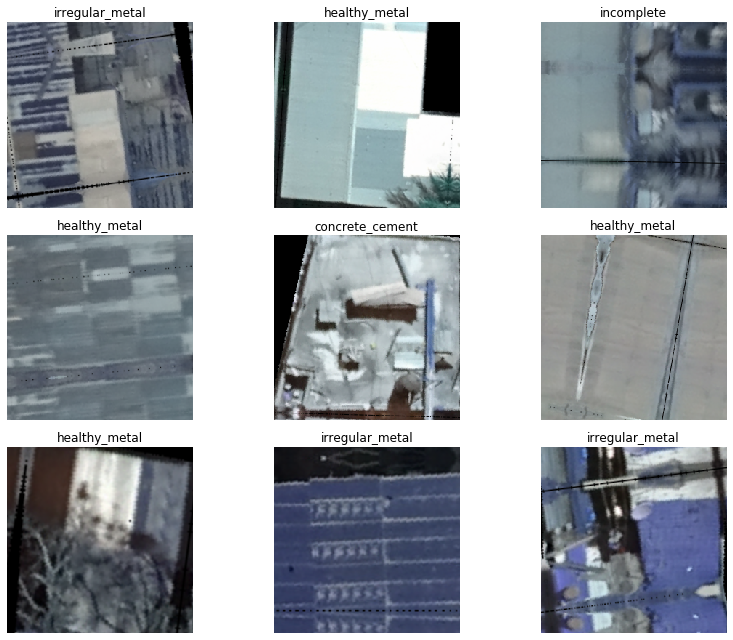

In [39]:
data.show_batch(rows=3, figsize=(12,9))

In [40]:
def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

### Model

In [41]:
# "pretrained" is hardcoded to adapt to the PyTorch model function
def efficient_net_b3(pretrained=True):
    model = EfficientNet.from_pretrained('efficientnet-b3')
    return nn.Sequential(model)

In [42]:
model_meta[efficient_net_b3] =  { 'cut': noop, 
                               'split': lambda m: (list(m[0][0].children())[2][7], m[1]) }

In [43]:
list(efficient_net_b3()[0].children())

Loaded pretrained weights for efficientnet-b3


[Conv2dStaticSamePadding(
   3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
   (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
 ),
 BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 ModuleList(
   (0): MBConvBlock(
     (_depthwise_conv): Conv2dStaticSamePadding(
       40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
       (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
     )
     (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_se_reduce): Conv2dStaticSamePadding(
       40, 10, kernel_size=(1, 1), stride=(1, 1)
       (static_padding): Identity()
     )
     (_se_expand): Conv2dStaticSamePadding(
       10, 40, kernel_size=(1, 1), stride=(1, 1)
       (static_padding): Identity()
     )
     (_project_conv): Conv2dStaticSamePadding(
       40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
       (static_padding): Identi

In [44]:
output_size = list(efficient_net_b3()[0].children())[-2].out_features

Loaded pretrained weights for efficientnet-b3


In [45]:
output_size

1000

In [46]:
custom_head = nn.Linear(output_size, data.c)

In [47]:
arch = efficient_net_b3
arch_name = 'efficient_net_b3'

In [48]:
learn = cnn_learner(data, arch, custom_head = custom_head, metrics=error_rate, bn_final=True).to_fp16()

Loaded pretrained weights for efficientnet-b3


In [49]:
get_groups(nn.Sequential(*list(learn.model[0][0].children())[:2], 
                         *list(learn.model[0][0].children())[2],
                         *list(learn.model[0][0].children())[3:],
                         learn.model[1]), 
           learn.layer_groups)

Group 1: ['Conv2dStaticSamePadding', 'BatchNorm2d', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock']
Group 2: ['MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'Conv2dStaticSamePadding', 'BatchNorm2d', 'AdaptiveAvgPool2d', 'Dropout', 'Linear', 'MemoryEfficientSwish']
Group 3: ['Linear']


In [50]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### train model

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


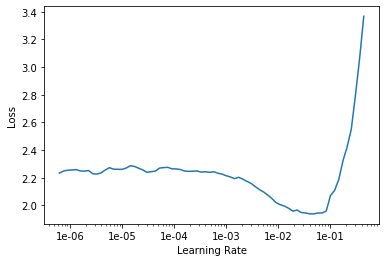

In [52]:
learn.recorder.plot()

Then we can fit the head of our network.

In [53]:
lr = 5e-3

In [54]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.002939,0.944546,0.369200,02:13
1,1.025265,0.827267,0.311365,02:05
2,0.883583,0.735998,0.272360,02:05
3,0.765888,0.676138,0.272360,02:06
4,0.692453,0.652660,0.269670,02:07


In [55]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [56]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.767514,0.727238,0.275723,02:05
1,0.854865,0.777497,0.293880,02:05
2,0.788198,0.695375,0.258238,02:01
3,0.670362,0.618713,0.225958,02:03
4,0.649781,0.604918,0.226631,02:00


In [57]:
learn.save(f'stage-1b-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [58]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.696845,0.664286,0.242771,02:00
1,0.767397,0.723437,0.244116,01:55
2,0.688641,0.638603,0.227976,01:49
3,0.647577,0.591174,0.219233,01:49
4,0.617887,0.581113,0.219233,01:49


In [59]:
learn.save(f'stage-1c-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [60]:
learn.load(f'stage-1b-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (13383 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (1487 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=Tr

In [61]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 137),
 ('healthy_metal', 'irregular_metal', 76),
 ('incomplete', 'irregular_metal', 22),
 ('concrete_cement', 'healthy_metal', 19),
 ('irregular_metal', 'concrete_cement', 12),
 ('concrete_cement', 'irregular_metal', 11),
 ('incomplete', 'concrete_cement', 10),
 ('other', 'irregular_metal', 10),
 ('healthy_metal', 'concrete_cement', 8),
 ('irregular_metal', 'incomplete', 8),
 ('incomplete', 'healthy_metal', 6),
 ('other', 'healthy_metal', 5),
 ('concrete_cement', 'incomplete', 4),
 ('healthy_metal', 'incomplete', 4),
 ('healthy_metal', 'other', 3),
 ('irregular_metal', 'other', 2)]

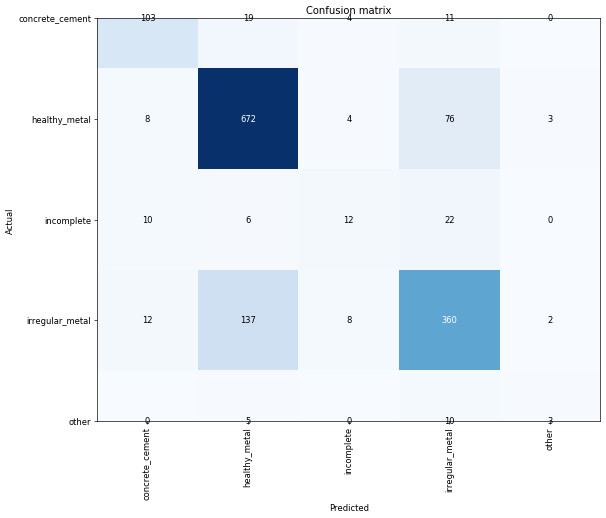

In [62]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [63]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


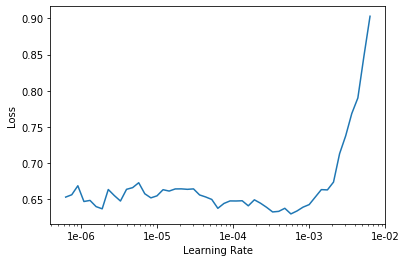

In [64]:
learn.lr_find()
learn.recorder.plot()

In [65]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.645964,0.596875,0.233356,02:32
1,0.573980,0.568952,0.207801,02:33
2,0.541523,0.507375,0.195024,02:32
3,0.452602,0.487034,0.179556,02:35
4,0.402985,0.489468,0.178211,02:35


In [66]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [51]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (13383 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (1487 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=Tr

In [68]:
learn.fit_one_cycle(5, slice(1e-6, lr/8))

epoch,train_loss,valid_loss,error_rate,time
0,0.434437,0.487719,0.185609,02:34
1,0.421608,0.493453,0.176866,02:33
2,0.390192,0.489473,0.176866,02:33
3,0.401050,0.492809,0.183591,02:27
4,0.362448,0.490672,0.177539,02:29


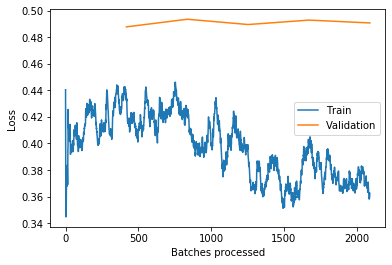

In [69]:
learn.recorder.plot_losses()

In [70]:
learn.save(f'stage-2b-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [71]:
learn.load(f'stage-2b-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (13383 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (1487 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=Tr

In [72]:
learn = learn.to_fp32()

In [73]:
learn.export(f'stage-2b-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [74]:
learn.export()

### 20191030 up to here, TOTO inference

### Larger size images

In [52]:
bs=16

In [53]:
data = (src.transform(tfms, size=256)
        .databunch(bs=bs).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [54]:
learn=learn.to_fp16()

In [55]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


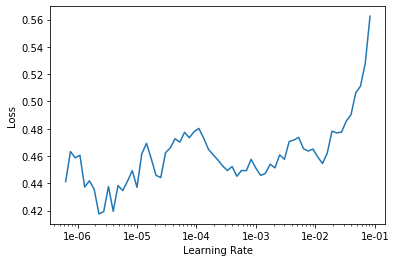

In [56]:
learn.lr_find()
learn.recorder.plot()

In [57]:
lr=1e-6

In [58]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.456788,0.491045,0.176194,03:11
1,0.449857,0.495422,0.184264,03:10
2,0.446650,0.492649,0.182919,03:07
3,0.446231,0.492176,0.177539,03:16
4,0.433561,0.494236,0.180229,03:13


In [59]:
learn.save(f'stage-1-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [60]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


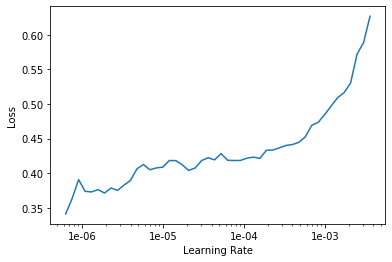

In [61]:
learn.lr_find()
learn.recorder.plot()

In [62]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.460526,0.491715,0.177539,05:12
1,0.419892,0.488910,0.178211,04:19
2,0.477688,0.491470,0.182919,04:26
3,0.454752,0.491201,0.180901,05:46
4,0.459714,0.487062,0.179556,04:30


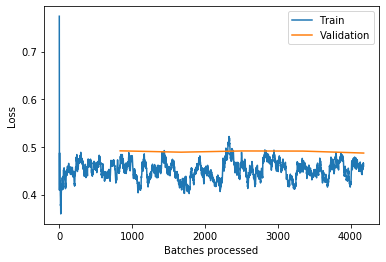

In [63]:
learn.recorder.plot_losses()

In [65]:
learn.save(f'stage-2-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

### inference

In [ ]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [ ]:
len(test_dataset)

In [ ]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [ ]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [ ]:
learn.data.loss_func

In [ ]:
type(learn.data)

In [ ]:
type(learn.dl(DatasetType.Test))

In [ ]:
len(learn.dl(DatasetType.Test))

Get number of items in the Valid dataset (in DeviceDataLoader)

In [ ]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [ ]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
labels = np.argmax(preds, 1)

In [ ]:
len(preds)

In [ ]:
preds[0].tolist()

In [ ]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [ ]:
len(labels)

In [ ]:
learn.data.classes

In [ ]:
data.classes

In [ ]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [ ]:
test_predictions[0]

In [ ]:
type(learn.data.test_ds)

In [ ]:
 learn.data.test_ds.x.items

In [ ]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [ ]:
preds_list[0]

In [ ]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [ ]:
cols

In [ ]:
df.head()

In [ ]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [ ]:
pred_df.insert(loc=0, column='id', value=ids)

In [ ]:
pred_df.columns = cols

In [ ]:
pred_df.head()

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [ ]:
#pred_df = pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [ ]:
pred_df.head()

In [ ]:
pred_ids=pred_df['id'].values.tolist()

In [ ]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [ ]:
df_baseline.head()

In [ ]:
baseline_ids=df_baseline['id'].values.tolist()

In [ ]:
baseline_ids

In [ ]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [ ]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [ ]:
pred_df.head()

In [ ]:
pred_df=pred_df.sort_values('id_cat')

In [ ]:
pred_df.head()

In [ ]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [ ]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [ ]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [ ]:
### Submission 2: 0.4461


In [ ]:

pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [ ]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")